In [1]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import os

from var import *

In [2]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [3]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/cell_state/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

## 1. Evaluate heterogeneous cell state response

In [4]:
#load log normalised adata object with filter for cells with more than 5000 UMI counts expressed
adata_preprocessed = sc.read_h5ad(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230116_adata_pre_processed.h5ad')

In [5]:
#load adata obs object from crispra csv file
adata_obs_df=pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/20230202_perturbation_state.csv', index_col=0)
#order index of adata_obs_df to match adata_preprocessed
adata_obs_df = adata_obs_df.reindex(adata_preprocessed.obs.index)
#check that the index of adata_obs_df matches adata_preprocessed
assert adata_obs_df.index.equals(adata_preprocessed.obs.index)
#overwrite adata_preprocessed.obs with adata_obs_df
adata_preprocessed.obs = adata_obs_df

#filter out cells that are not in the perturbation state
adata_perturbed = adata_preprocessed[adata_preprocessed.obs['perturbation_state'] != 'not_perturbed']

In [6]:
guides = adata_perturbed.var_names.str.rstrip('_1|_2').unique()

In [7]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata_preprocessed.var_names[~adata_preprocessed.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [8]:

# Create a list of expected guides including the control guides 
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

[i for i in expected_guides if i not in targeted_tf]

['sgRNA1_SCP', 'sgRNA6_SCP', 'ONE_INTERGENIC_SITE_1194']

In [10]:
expected_tf = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2'
]

In [11]:
#compute np log 1 p on adata_perturbed counts layers
adata_perturbed.layers['log1p'] = np.log1p(adata_perturbed.layers['counts'])

### 1.1 Target gene vs. guide count correlation

In [ ]:
#plot scatter plot x axis UMI counts for perturbed cells and y axis target gene expression
rows = np.ceil(len(expected_tf)/3.0).astype(int)
fig, axs = plt.subplots(rows, 3, figsize=(10, rows*3))
#avoid overlap between subplots
fig.tight_layout(pad=3.0)

guides = adata_perturbed.var_names.str.rstrip('_1|_2').unique()
for i, short_name in enumerate(expected_guides):
    tmp_guides = guides[guides.str.contains(short_name)]
    

    
    if len(tmp_guides) == 2:
        #create empty list to store fraction of each guide pair
        
            
        tmp_adata= adata_perturbed[:,adata_perturbed.var_names.str.contains(short_name)]
        #calculate fraction of each guide pair
        tmp_sum_perturbation = tmp_adata.layers['log1p'].sum(axis=1)
        #convert to matrix to array and reshape
        tmp_sum_perturbation = np.array(tmp_sum_perturbation).reshape(-1)

        #filter adata_perturbedrbed for counts of target gene based on short name
        tmp_target = adata_perturbed[:,adata_perturbed.var['SYMBOL'] == short_name].layers['log1p']
        #convert to array and reshape
        tmp_target = tmp_target.toarray().reshape(-1)

        
        axs[divmod(i,3)].hist2d(tmp_sum_perturbation,tmp_target,bins=100,density=True, 
                        norm = colors.LogNorm())

        #add x and y label
        axs[divmod(i,3)].set_xlabel(f'{short_name} guide pair count (log1p)')
        axs[divmod(i,3)].set_ylabel(f'{short_name} target count (log1)')
        
        

#remove empty subplots
for i in range(len(expected_tf), rows*3):
    fig.delaxes(axs[divmod(i,3)])

#save figure
#fig.savefig(os.path.join(figures_folder, f'{today}_guide_pair_v_target_gene_count.pdf'), dpi=300, bbox_inches='tight')

In [ ]:
#subset adata for each perturbation state by looping
guides = adata_perturbed.var_names.str.rstrip('_1|_2').unique()
#create subfolder in figures folder to store figures if it does not exist
target_gene_expression_folder = os.path.join(figures_folder, 'guide_pair_v_target_gene_count')
if not os.path.exists(target_gene_expression_folder):
    os.makedirs(target_gene_expression_folder)

for short_name in expected_guides:
    #map short_name to var_names using .var
    tmp_ENSG= adata_perturbed[:,adata_perturbed.var['SYMBOL']==short_name].var_names
        
    if len(tmp_ENSG) == 1:

        #create subplots 
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        #subset adata_perturbed for each perturbation state and control
        tmp_adata = adata_perturbed[adata_perturbed.obs['perturbation_state'].isin([short_name,'non_activating'])]
        


        #plot UMAP for target gene expression and perturbation state
        sc.pl.umap(tmp_adata, color=[short_name], show=False,title=short_name,gene_symbols='SYMBOL')
        sc.pl.umap(tmp_adata, color='perturbation_state', show=False)

        # #save figure
        # fig.savefig(os.path.join(target_gene_expression_folder, f'{today}_{short_name}_UMAP.pdf'), dpi=300, bbox_inches='tight')
            


### 1.2 Explore loss of stemness in perturbed cells

In [ ]:
#plot pluripotency marker genes in umap
#marker list based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6028138/#!po=13.4615
sc.pl.umap(adata_preprocessed, color=['NANOG','SOX2','KLF4','POU5F1','DNMT3B','NODAL','UTF1','LEFTY2'],gene_symbols='SYMBOL',cmap='viridis')
# #save umap plot
# plt.savefig(os.path.join(figures_folder, f'{today}_cell_cycle_wo_reg_pluripotency_markers.pdf'), dpi=300, bbox_inches='tight')

### 1.3 Cofactor analysis

In [26]:
# load cofactor csv as pandas dataframe
cofactor_df = pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/cofactor_functionality.csv')
cofactor_df['cofactors'] = cofactor_df['cofactors'].str.replace(r"\s+",'',regex=True)

#all capital letter
cofactor_df['cofactors'] = cofactor_df['cofactors'].str.upper()

In [27]:
cofactor_df['functionality'].unique()

array(['Chromatin remodellers', 'Mediator complex',
       'Mediator Kinase Module', 'Nuclear receptor coactivator', 'TFIIA',
       'TFIIB', 'TFIIE', 'TFIIF', 'TFIIH', 'Pol II',
       'Histone acetyltransferases', 'TFIID', nan, 'Integrator complex',
       'Set/COMPASS complex', 'FACT complex', 'Nelf/Dsif complex',
       'Elongation'], dtype=object)

['CHD1', 'SMARCA5', 'MAZ', 'BPTF', 'ARID1A', 'ARID1B', 'ARID2', 'ARID4A', 'ARID4B', 'RUVBL1', 'RUVBL2', 'SMARCB1', 'IN080B', 'SMARCA4', 'SMARCD1', 'SMARCA1', 'SMARCC1', 'SMARCC2', 'SMARCD2', 'SMARCD3', 'SMARCE1', 'BRD9', 'SMARCAD1']
22


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['MED18', 'MED20', 'MED8', 'MED27', 'MED6', 'MED4', 'MED19', 'MED15', 'MED17', 'MED14', 'MED21', 'MED31', 'MED1', 'MED11', 'MED23', 'MED16', 'MED24', 'MED25']
18


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['MED12', 'MED13', 'CDK8']
3


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['NCOA1', 'NCOA6', 'NCOA3']
3


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['GTF2A1', 'GTF2A2']
2


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['GTF2B']
1


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['GTF2E1', 'GTF2E2']
2


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['GTF2F1', 'GTF2F2']
2


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['ERCC3', 'GTF2H1', 'ERCC2', 'CDK7', 'CCNH', 'GTF2H2', 'MNAT1', 'GTF2H4']
8


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['POLR2B', 'POLR2C', 'POLR2A', 'POLR2D', 'POLR2J', 'POLR2K', 'POLR2H', 'POLR2E', 'POLR2G', 'POLR2F']
10


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['EP300', 'CREBBP', 'EP400', 'KAT2A', 'KAT2B', 'KAT5', 'KAT6A', 'KAT6B', 'KAT8']
8


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['TAF4', 'TAF12', 'TAF1', 'TPB', 'TAF7', 'TAF3', 'TAF6', 'TAF5', 'TAF10', 'TAF11', 'TAF13', 'TAF8', 'TAF2']
12


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


[]
0
['INTS1', 'INTS4', 'INTS7', 'INTS2', 'INTS5', 'INTS8', 'INTS10', 'INTS9', 'INTS12']
9


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['ASH21', 'SETD1B', 'DPУ30', 'CXXC1', 'WDR82', 'WDR5', 'RBBP5', 'KMT2A', 'KMT2B', 'KMT2D']
8


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['SUPT16H', 'SSRP1']
2


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['NELFA', 'NELFB', 'SUPT4H1', 'SUPT5H', 'SUPT6H', 'NELFCD', 'NELFE']
7


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


['AFF1', 'LEO1', 'DOT1L', 'ELL', 'CTR9', 'PAF1', 'CDC73', 'WDR61', 'ELOA', 'UBE2A', 'HUWE1', 'MILT1', 'MILT10', 'MILT3', 'TRIM28', 'AFF4']
13


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


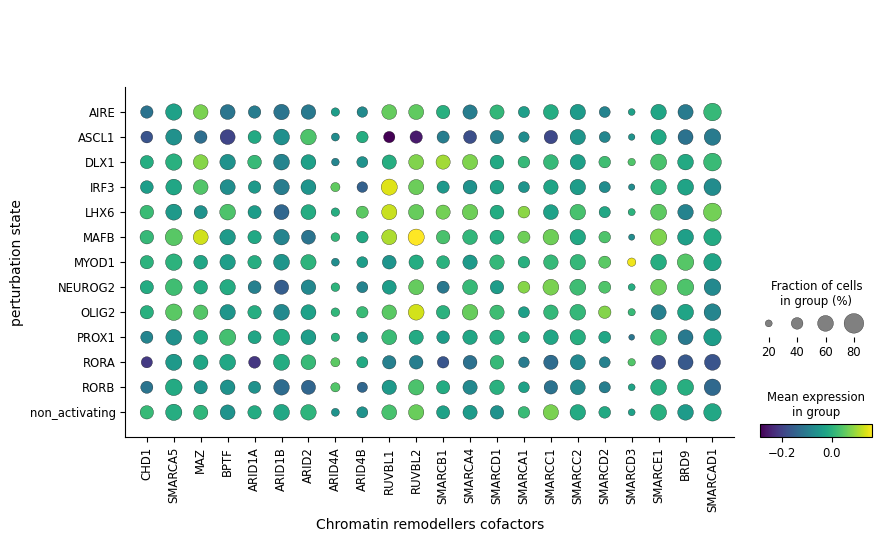

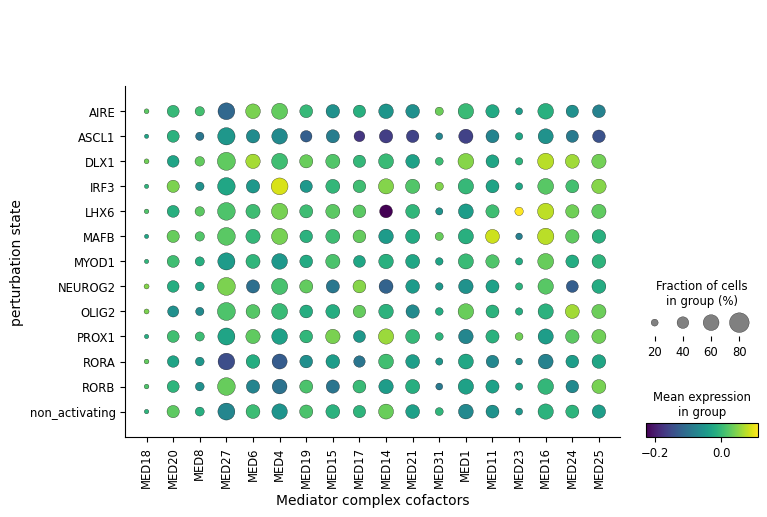

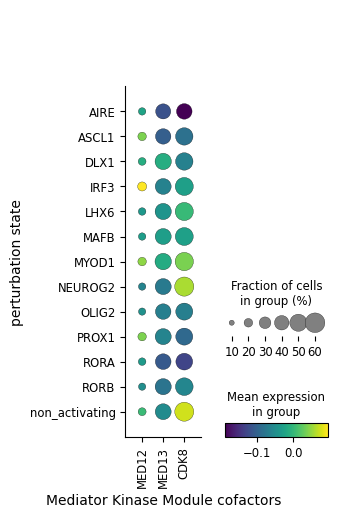

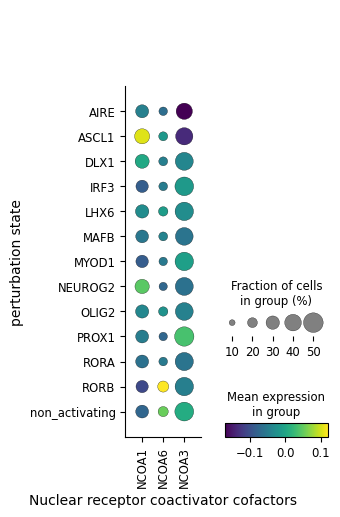

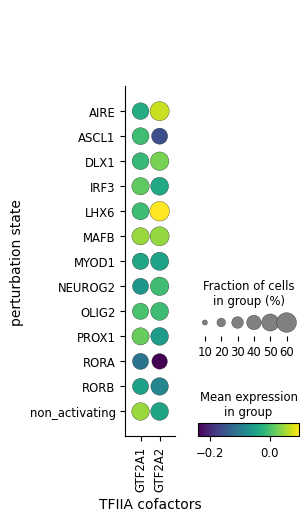

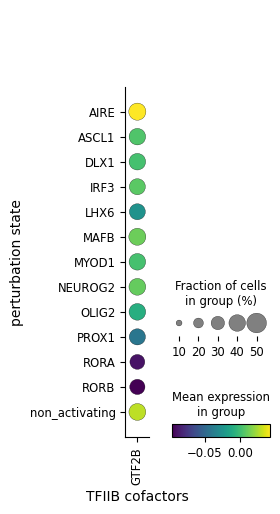

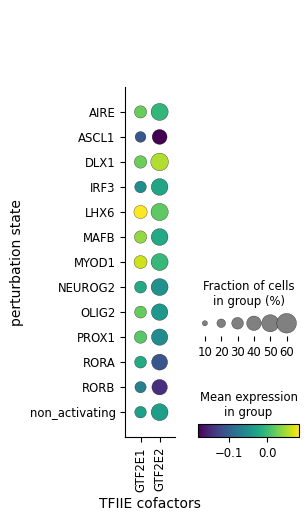

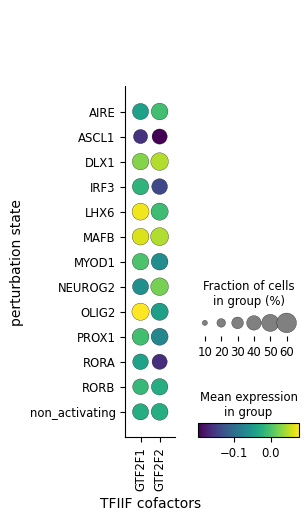

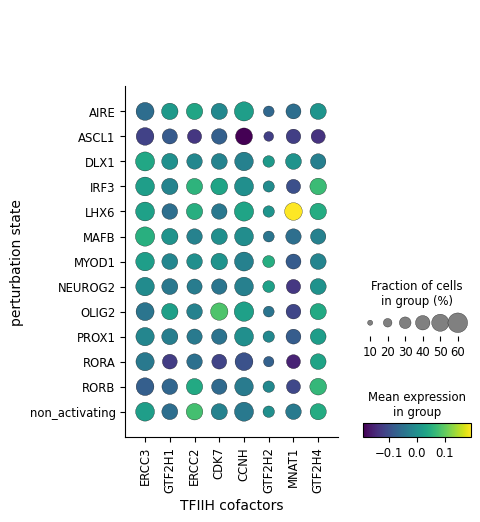

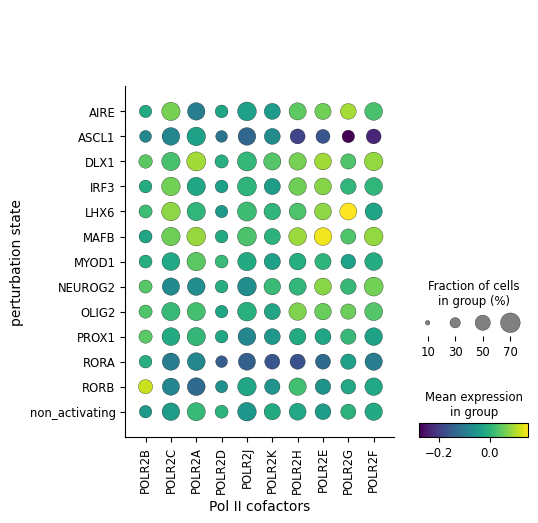

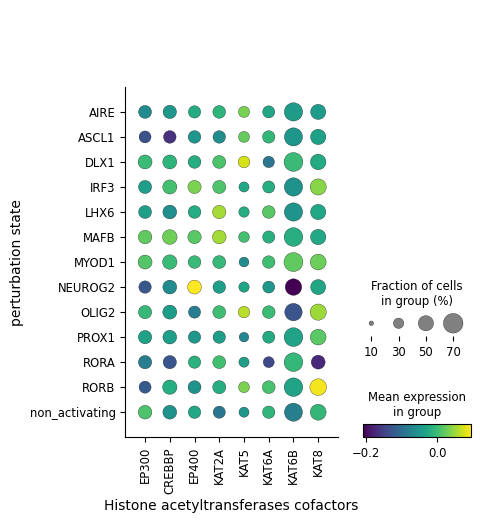

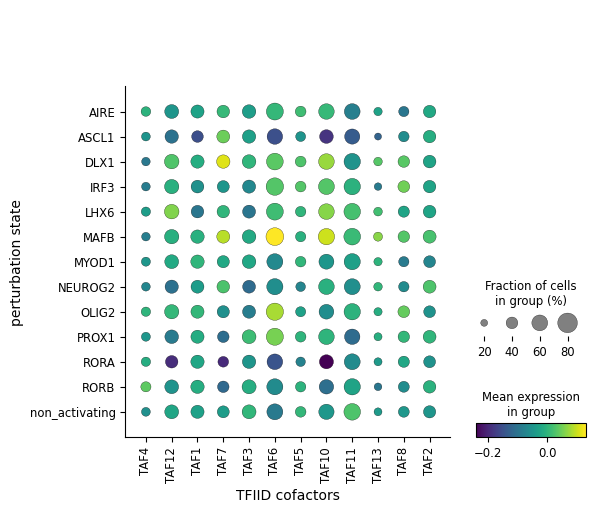

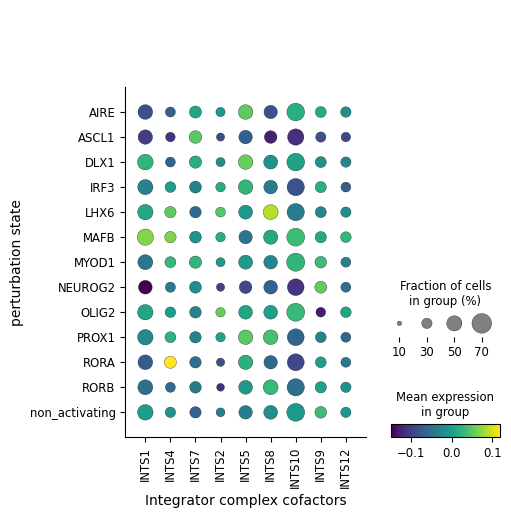

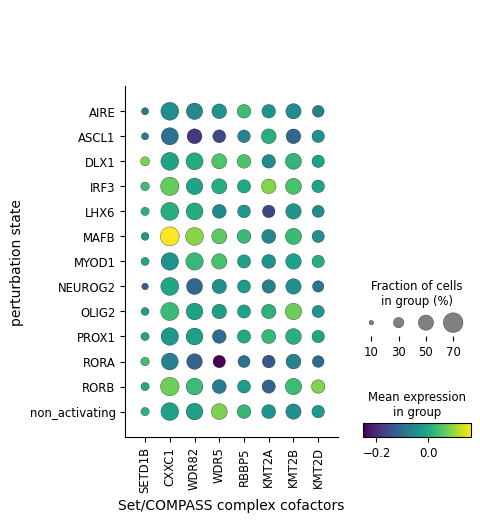

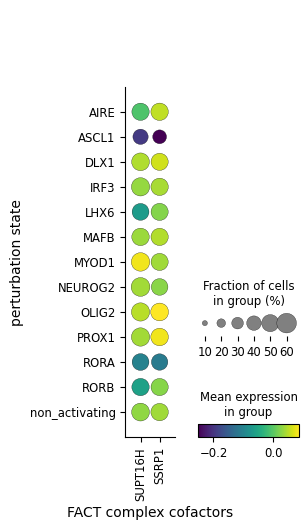

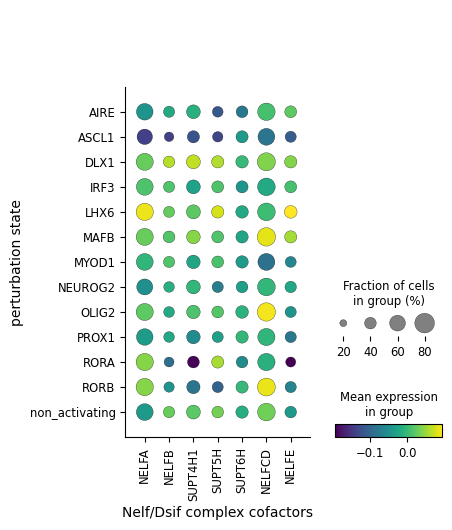

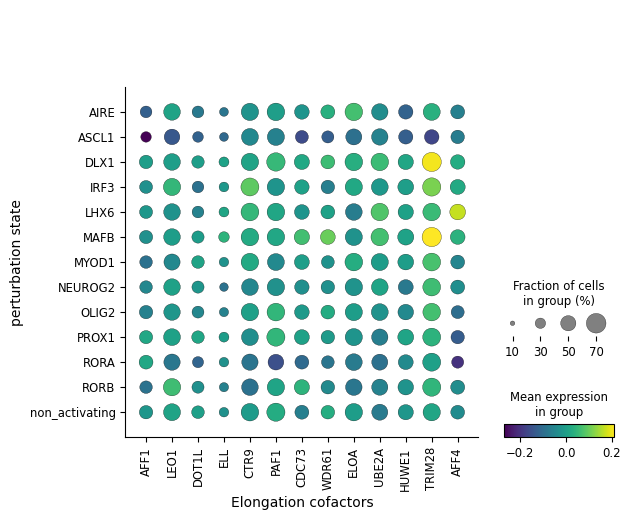

In [28]:
#plot cofactor in umap of adatapreprocessed
for func in cofactor_df['functionality'].unique():
    tmp_cofactors = cofactor_df[cofactor_df['functionality']==func]['cofactors'].to_list()
    print(tmp_cofactors)
    #filter for only cofactors found in adatapreprocessed SYMBOL
    tmp_cofactors = [x for x in tmp_cofactors if x in adata_perturbed.var['SYMBOL'].to_list()]
    print(len(tmp_cofactors))
    #exclude SATB2 pertubation state due to its low abundance
    adata_perturbed = adata_perturbed[adata_perturbed.obs['perturbation_state']!='SATB2']
    if len(tmp_cofactors)>0:
        ax=sc.pl.dotplot(adata_perturbed, tmp_cofactors, groupby='perturbation_state',gene_symbols='SYMBOL',cmap='viridis',show=False)
        #add x and y label
        ax['mainplot_ax'].set_xlabel(f'{func} cofactors')
        ax['mainplot_ax'].set_ylabel('perturbation state')

        #string replace for saving figure
        func = func.replace(' ','_')
        func = func.replace('/','_')
        
        #save umap plot
        plt.savefig(os.path.join(figures_folder, f'{today}_{func}_cofactor_analysis.pdf'), dpi=300, bbox_inches='tight')
